# Problem statement

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers).

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We are developing a Machine Learning algorithm that, using this knowledge base as a baseline and automatically classifies genetic variations.

This problem was launched by Memorial Sloan Kettering Cancer Center (MSKCC), accepted by NIPS 2017 Competition Track and determines the best model in terms of Log Loss

Data link for the problem: https://www.kaggle.com/c/msk-redefining-cancer-treatment


## Analysis of the problem statement

In [1]:
# Loading all required packages
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
import seaborn as sns
import math
import plotly.plotly as py
import cufflinks as cf

from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from plotly import __version__
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
cf.go_offline()

warnings.filterwarnings("ignore")

## Loading Data Files

In [2]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('training_variants')

# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv('training_text',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [3]:
#Exploring data_variants
data_variants.head(10)

ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4
5   5     CBL                 V391I      4
6   6     CBL                 V430M      5
7   7     CBL              Deletion      1
8   8     CBL                 Y371H      4
9   9     CBL                 C384R      4

DATA DESCRIPTION

ID : row id used to link the mutation to the clinical evidence

Gene : the gene where this genetic mutation is located

Variation : the aminoacid change for this mutations

Class : class value 1-9, this genetic mutation has been classified on


In [4]:
#Getting data information
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [5]:
#Description for numeric columns
data_variants.describe()

ID        Class
count  3321.000000  3321.000000
mean   1660.000000     4.365854
std     958.834449     2.309781
min       0.000000     1.000000
25%     830.000000     2.000000
50%    1660.000000     4.000000
75%    2490.000000     7.000000
max    3320.000000     9.000000

In [6]:
# Checking dimension of data
data_variants.shape

(3321, 4)

In [7]:
# Checking column in above data_variants
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [8]:
# Exploring data_text
data_text.head(10)

ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...
5   5  Oncogenic mutations in the monomeric Casitas B...
6   6  Oncogenic mutations in the monomeric Casitas B...
7   7  CBL is a negative regulator of activated recep...
8   8   Abstract Juvenile myelomonocytic leukemia (JM...
9   9   Abstract Juvenile myelomonocytic leukemia (JM...

In [9]:
#Getting data information
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [10]:
# Description for numeric columns
data_text.describe()

ID
count  3321.000000
mean   1660.000000
std     958.834449
min       0.000000
25%     830.000000
50%    1660.000000
75%    2490.000000
max    3320.000000

In [11]:
# Checking column in above data_text
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [12]:
# Checking the dimensions
data_text.shape

(3321, 2)

### Datasets looks like this

data_variants (ID, Gene, Variations, Class)

data_text(ID, text)


In [13]:
# We are trying to predict the class of cancer,hence we will check all the unique values that can be determined
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

### This is discrete data so it is classification problem and since there are multiple descrete output possible so we can call it Multi class classification problem

### Important note : This is medical related problem so correct results are very important. Error can be really costly here so we would like to have result for each class in terms of Probablity. The latency can be compromised to some extent given that we want the minimal error rate possible.

We also want our model to be highly interpretable because a medical practitioner would want to provide proper reasonining on why an algorithm is predicting a soecific class.

We will evaluate our model using Confusion matrix and Multi class log-loss, we will also plot precision and recall matrix for better understanding of the prediction

In [14]:
# We would like to remove all stop words like a, is, an, the, ... so we are collecting all of them from nltk(Natural Language
# Toolkit) library
stop_words = set(stopwords.words('english'))

In [15]:
def data_text_preprocess(total_text, ind, col):
    # Removing integer values from text data as that might not be important
    if type(total_text) is not int:
        string = ""
        # replacing all special characters with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bringing the whole text to lower-case
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [16]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

## Merging data_variants and data_text 

In [17]:
# Merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head(10)

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   
5   5     CBL                 V391I      4   
6   6     CBL                 V430M      5   
7   7     CBL              Deletion      1   
8   8     CBL                 Y371H      4   
9   9     CBL                 C384R      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...  
5  oncogenic mutations monomeric casitas b lineag...  
6  oncogenic mutations monomeric casitas b lineag...  
7  cbl negative regulator activated receptor tyro...  
8  abstract juvenile myelomonocytic leukemia jmml...  
9  abstract juvenile myelomonocytic leukemia jmml...

## Cleaning the data, handling missing values

In [18]:
result[result.isnull().any(axis=1)]

ID    Gene             Variation  Class TEXT
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN

There are only five rows with missing data. 
This can be dealt in two ways:
1. Removing these rows
2. Using Imputation(replacing the null values)

The missing data is handled using imputation by replacing the null values with Gene and Variation

In [19]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [20]:
# Cross checking the null values after imputation
result[result.isnull().any(axis=1)]

Empty DataFrame
Columns: [ID, Gene, Variation, Class, TEXT]
Index: []

## Creating Training, Test and Validation data

Before splitting the data into training, test and validation data set. We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [21]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [22]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# split the train data now into train and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [23]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


## Distribution of data in train, test and validation set

In [24]:
train_class_distribution = train_df['Class'].value_counts().sortlevel()
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

In [25]:
df_train= pd.DataFrame(train_class_distribution)
df_train.iplot(kind = 'bar',xTitle='Class',yTitle='Data points',title = 'Train Class Distribution',color = 'pink')

In [26]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


In [27]:
test_class_distribution = test_df['Class'].value_counts().sortlevel()
test_class_distribution

1    114
2     91
3     18
4    137
5     48
6     55
7    191
8      4
9      7
Name: Class, dtype: int64

In [28]:
df_train= pd.DataFrame(test_class_distribution)
df_train.iplot(kind = 'bar',xTitle='Class',yTitle='Data points',title = 'Test Class Distribution',color = 'red')

In [29]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


In [30]:
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()
cv_class_distribution

1     91
2     72
3     14
4    110
5     39
6     44
7    153
8      3
9      6
Name: Class, dtype: int64

In [31]:
df_train= pd.DataFrame(cv_class_distribution)
df_train.iplot(kind = 'bar',xTitle='Class',yTitle='Data points',title = 'Validation Class Distribution',color = 'blue')

In [32]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


Looking at the data point distribution for train, test and validation data we can safely say that the data distribution is similar in all the sets.

### For log-loss evaluation a random model is needed to compare the log loss against. Any successful model should return a lower log loss than this model

## Building a random model

In [33]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

### Log loss of validation set 

In [34]:
# Creating an output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))

for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.5023281416336216


### Log loss of test set

In [35]:
# Creating an output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.5193758549799172


In [36]:
# Getting the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

predicted_y

array([6, 0, 8, 0, 6, 2, 4, 2, 7, 5, 5, 5, 0, 7, 3, 3, 2, 0, 7, 7, 7, 1,
       4, 2, 6, 1, 7, 2, 1, 6, 8, 6, 0, 6, 5, 7, 3, 1, 7, 3, 6, 0, 5, 1,
       5, 4, 2, 8, 2, 5, 6, 0, 0, 7, 6, 3, 3, 0, 0, 3, 5, 4, 8, 5, 4, 4,
       8, 3, 8, 8, 0, 5, 7, 5, 0, 5, 8, 4, 5, 8, 7, 1, 4, 7, 3, 8, 0, 0,
       1, 5, 2, 0, 2, 1, 6, 8, 3, 1, 5, 0, 2, 0, 6, 5, 6, 2, 2, 6, 2, 3,
       1, 6, 2, 1, 3, 5, 8, 7, 7, 8, 6, 5, 5, 1, 4, 6, 3, 3, 8, 2, 2, 5,
       6, 6, 2, 0, 7, 7, 0, 2, 1, 2, 7, 3, 1, 5, 2, 2, 8, 4, 0, 1, 5, 3,
       1, 6, 8, 5, 8, 3, 4, 7, 2, 1, 1, 3, 4, 5, 1, 4, 2, 5, 6, 8, 3, 6,
       6, 7, 8, 8, 1, 8, 1, 4, 6, 6, 6, 2, 3, 8, 4, 1, 4, 5, 2, 3, 3, 5,
       6, 4, 3, 6, 4, 8, 4, 4, 6, 7, 2, 0, 6, 7, 7, 7, 0, 5, 3, 6, 0, 8,
       3, 3, 5, 6, 3, 6, 7, 2, 6, 4, 0, 2, 5, 7, 2, 1, 8, 5, 7, 1, 4, 3,
       6, 7, 7, 2, 4, 2, 2, 3, 0, 7, 2, 6, 7, 4, 1, 8, 7, 8, 5, 4, 5, 1,
       2, 4, 8, 5, 0, 5, 0, 2, 5, 3, 2, 2, 0, 1, 3, 3, 0, 3, 2, 8, 8, 1,
       8, 2, 2, 7, 3, 3, 6, 3, 3, 2, 8, 3, 3, 4, 8,

The index value ranges from 0 to 8. To rectify the value is increased by 1

In [37]:
predicted_y = predicted_y + 1

### Confusion Matrix

In [38]:
C = confusion_matrix(y_test, predicted_y)

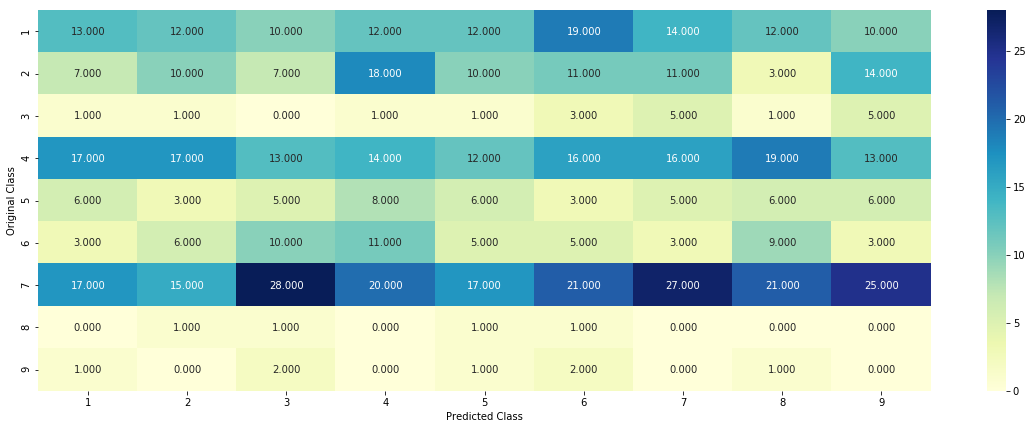

In [39]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### Precision Matrix

In [40]:
B =(C/C.sum(axis=0))

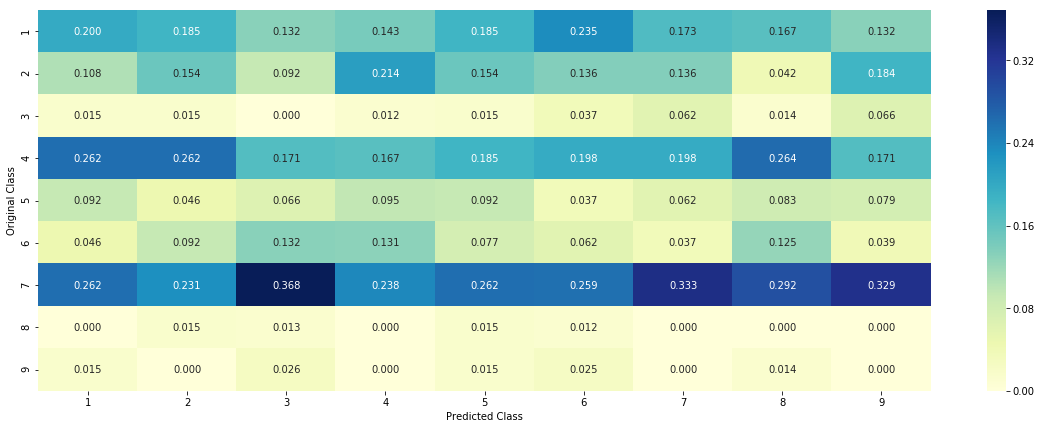

In [41]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### Recall Matrix

In [42]:
A =(((C.T)/(C.sum(axis=1))).T)

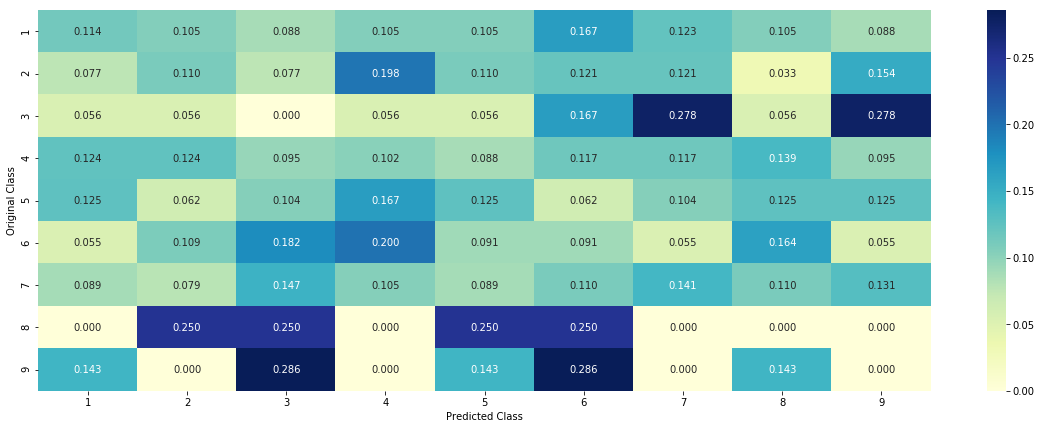

In [43]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Evaluating Gene Column

Determining if the independent column gene is relevant to the target variable.

In [44]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

# Top 10 genes
print(unique_genes.head(10))

Number of Unique Genes : 235
BRCA1     173
TP53      103
EGFR       87
PTEN       79
BRCA2      79
BRAF       66
KIT        62
ERBB2      47
ALK        42
PIK3CA     41
Name: Gene, dtype: int64


#### Cumulative distribution of unique Genes values

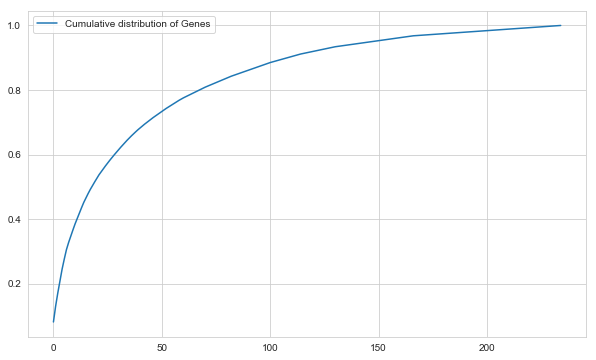

In [45]:
sns.set_style('whitegrid')
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.figure(figsize =(10,6))
plt.plot(c,label='Cumulative distribution of Genes')
plt.legend()
plt.show()

To convert this categorical variable to appropirate format machine learning algorithm will be used.

The 2 techniques to deal with it are:

1. ***One-hot encoding***
2. ***Response Encoding*** (Mean imputation)

In [46]:
# One-hot encoding of gene feature
gene_vectorizer = CountVectorizer()
# Train gene feature
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
# Test gene feature
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
# CV gene feature
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

### Column generated after one hot encoding

In [47]:
train_gene_feature_onehotCoding.shape

(2124, 235)

In [48]:
# Column names after one-hot encoding for gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl1',
 'asxl2',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'erg',
 'esr1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1

#### Function for Response encoding of gene column

In [49]:
# Code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']

# ALGORITHIM
# -------------------------------------------------------------------------------------------------
# Considering all unique values and the number of occurences of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha /
#                                           number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there in train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ------------------------------------------------------------------------------------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict

def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to particular class
        # vec is 9 dimensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

### Response-coding of the gene feature

In [50]:
# Alpha is used for laplace smoothing
alpha = 1
# Train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# Test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# Cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

#### Columns after applying response encoding

In [51]:
train_gene_feature_responseCoding.shape

(2124, 9)

#### Determining if gene column is a good feature for predicting the target variable Class

In [52]:
# Hyperparemeter for SGD(Stochastic Gradient Descent) classifier
alpha = [10 ** x for x in range(-5, 1)]

# Using SGD classifier
# Using Calibrated Classifier to get the result into probablity format to be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.387356918321714
For values of alpha =  0.0001 The log loss is: 1.204647188624542
For values of alpha =  0.001 The log loss is: 1.225190674063746
For values of alpha =  0.01 The log loss is: 1.3344203670186907
For values of alpha =  0.1 The log loss is: 1.4420151504926362
For values of alpha =  1 The log loss is: 1.4780634482237915


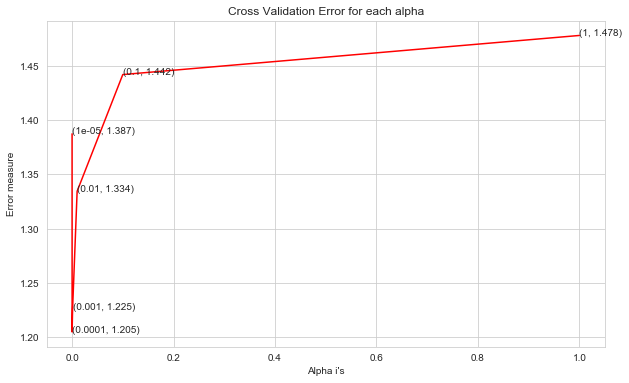

In [53]:
# Determining the best Alpha value
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize =(10,6))
ax.plot(alpha, cv_log_error_array,c='red')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [54]:
# Using best alpha value from the above graph to compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 1.0428555929129335
For values of best alpha =  0.0001 The cross validation log loss is: 1.204647188624542
For values of best alpha =  0.0001 The test log loss is: 1.2041277394919132


#### Checking overlapping between train, test or between validation and train

In [55]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [56]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 650 out of 665 : 97.74436090225564
2. In cross validation data 511 out of  532 : 96.05263157894737


## Evaluating Variation column

Variation is also a categorical variable and can be dealt with the same way as Gene column

In [57]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1921
Truncating_Mutations    64
Amplification           48
Deletion                46
Fusions                 23
Overexpression           5
G12V                     4
E330K                    2
M1R                      2
T73I                     2
Q22K                     2
Name: Variation, dtype: int64


#### Cumulative distribution of unique variation values

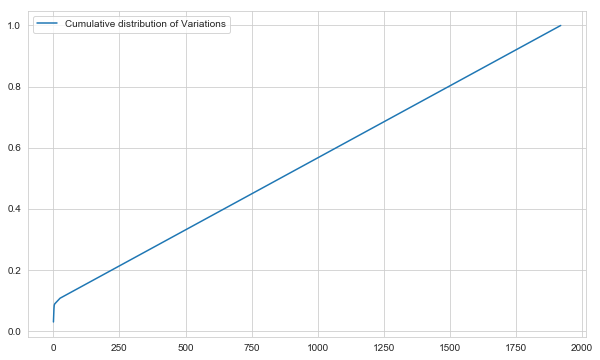

In [58]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
plt.figure(figsize = (10,6))
plt.plot(c,label='Cumulative distribution of Variations')
plt.legend()
plt.show()

#### Converting variation column using one hot encoder

In [59]:
# One-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

#### Shape of one hot encoder column for variation

In [60]:
train_variation_feature_onehotCoding.shape

(2124, 1950)

#### Generating response encoding for variation column

In [61]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

#### Shape of response encoding result

In [62]:
train_variation_feature_responseCoding.shape

(2124, 9)

#### Building the model with variation column

In [63]:
# Hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

# Using SGD classifier
# Using Calibrated Classifier to get the result into probablity format to be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7158492900832876
For values of alpha =  0.0001 The log loss is: 1.6976071949187521
For values of alpha =  0.001 The log loss is: 1.6939084673846028
For values of alpha =  0.01 The log loss is: 1.7035660818077503
For values of alpha =  0.1 The log loss is: 1.7068762692693953
For values of alpha =  1 The log loss is: 1.7093110998585368


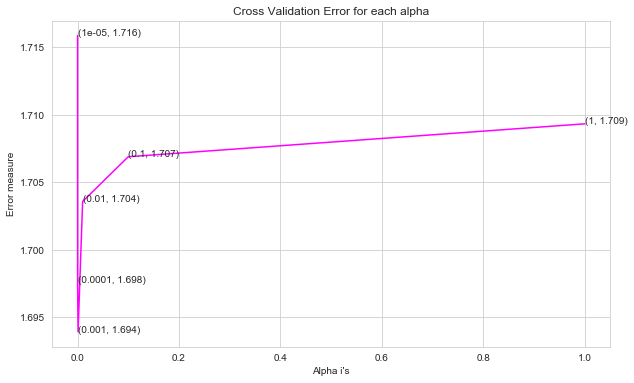

In [64]:
# Plot to check the best Alpha value
fig, ax = plt.subplots(figsize =(10,6))
ax.plot(alpha, cv_log_error_array,c='magenta')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [65]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 1.0545844440134642
For values of best alpha =  0.001 The cross validation log loss is: 1.6939084673846028
For values of best alpha =  0.001 The test log loss is: 1.7490165092532433


In [66]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 50 out of 665 : 7.518796992481203
2. In cross validation data 66 out of  532 : 12.406015037593985


## Evaluating Text column

In [67]:
# cls_text is a data frame
# for every row in data frame considering'TEXT'
# splitting the words by space
# making a dictionary with those words
# incrementing its count whenever that word is encountered

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [68]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [69]:
# building a CountVectorizer with all the words that occurred minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52944


In [70]:
dict_list = []
# dict_list =[] contains 9 dictionaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dictionary based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [71]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [72]:
# Converting each row value such that they sum to 1 
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [73]:
# Normalizing every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# Using the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])

# Normalizing every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# Using the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

# Normalizing every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [74]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [75]:
# Number of words for a given frequency
print(Counter(sorted_text_occur))

Counter({3: 5591, 4: 3542, 5: 2967, 6: 2809, 7: 2042, 9: 1827, 8: 1689, 12: 1431, 11: 1407, 10: 1402, 13: 1042, 15: 852, 14: 792, 18: 665, 16: 642, 19: 547, 17: 545, 20: 539, 22: 514, 24: 485, 21: 478, 25: 474, 29: 410, 23: 388, 30: 371, 41: 343, 26: 332, 28: 330, 27: 329, 35: 273, 47: 267, 33: 265, 32: 259, 36: 249, 31: 248, 42: 240, 40: 218, 34: 214, 44: 202, 37: 200, 39: 196, 55: 188, 48: 185, 38: 184, 43: 181, 46: 177, 45: 171, 50: 160, 60: 151, 56: 144, 54: 144, 53: 144, 52: 141, 51: 134, 49: 133, 58: 122, 63: 117, 62: 117, 57: 117, 66: 111, 67: 110, 61: 104, 65: 101, 75: 96, 64: 96, 59: 92, 82: 90, 69: 89, 70: 87, 84: 86, 78: 85, 86: 84, 74: 84, 71: 83, 73: 81, 68: 81, 90: 80, 91: 79, 72: 76, 76: 74, 104: 72, 85: 72, 79: 72, 77: 71, 94: 68, 83: 65, 80: 65, 102: 64, 99: 64, 92: 64, 108: 62, 95: 62, 81: 62, 88: 61, 97: 60, 96: 60, 87: 59, 89: 57, 100: 56, 98: 54, 93: 54, 145: 53, 120: 53, 103: 53, 101: 53, 127: 52, 106: 48, 117: 47, 105: 47, 118: 46, 114: 45, 121: 44, 144: 43, 131:

#### Building the model with text column

In [76]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.380852800963273
For values of alpha =  0.0001 The log loss is: 1.3436221216145368
For values of alpha =  0.001 The log loss is: 1.2092566062143748
For values of alpha =  0.01 The log loss is: 1.2450195280821061
For values of alpha =  0.1 The log loss is: 1.4305428803509774
For values of alpha =  1 The log loss is: 1.629638342330641


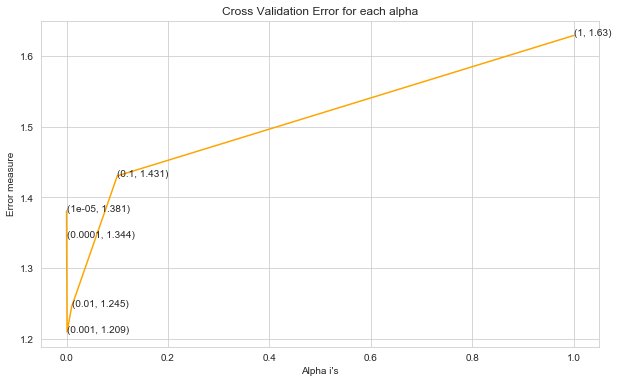

In [77]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='orange')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [78]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.7706219170699653
For values of best alpha =  0.001 The cross validation log loss is: 1.2092566062143748
For values of best alpha =  0.001 The test log loss is: 1.1949257098644281


#### Checking the overlap of text data

In [79]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [80]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.511 % of word of test data appeared in train data
97.598 % of word of Cross Validation appeared in train data


Therefore, all 3 columns are going to be important.Gene column has less log loss with respect to the random model and 
good overlap. Variation column has less overlap but log loss is less with respect to the random model. Text column has 
high overlap and less log loss with respect to the random model.

## Data Preparation for Machine Learning models

#### Functions that will be used

In [81]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [82]:
# Used to plot the confusion matrices
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss an array of probabilities is provided that belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [83]:
# Function for naive bayes
# for the given indices,the name of the features would be printed
# and it would be checked  whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## Combining all 3 features together

In [84]:
# Merging gene, variation and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

### One-hot encoding
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

### Response Encoding
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [85]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55129)
(number of data points * number of features) in test data =  (665, 55129)
(number of data points * number of features) in cross validation data = (532, 55129)


In [86]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## Building Machine Learning models

### Naive Bayes

In [87]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # To avoid rounding error while multiplying probabilites log-probability estimates are being used
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

For alpha = 1e-05
Log Loss : 1.3067354139545277
For alpha = 0.0001
Log Loss : 1.3005878983977681
For alpha = 0.001
Log Loss : 1.2995735358999077
For alpha = 0.1
Log Loss : 1.2699624495147508
For alpha = 1
Log Loss : 1.248332898058064
For alpha = 10
Log Loss : 1.3523810443218724
For alpha = 100
Log Loss : 1.336701491933338
For alpha = 1000
Log Loss : 1.2799052194045288


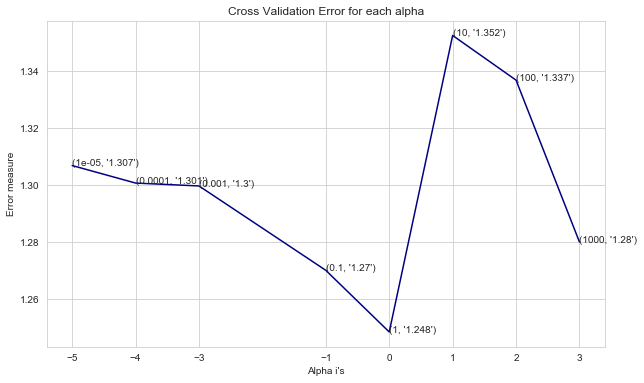

In [88]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(np.log10(alpha), cv_log_error_array,c='navy')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [89]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  1 The train log loss is: 0.9014618597278801
For values of best alpha =  1 The cross validation log loss is: 1.248332898058064
For values of best alpha =  1 The test log loss is: 1.2721582404332723


#### Testing Naive Bayes model with best found value of alpha on testing data

Log Loss : 1.248332898058064
Number of Misclassified points : 0.38345864661654133
-------------------- Confusion matrix --------------------


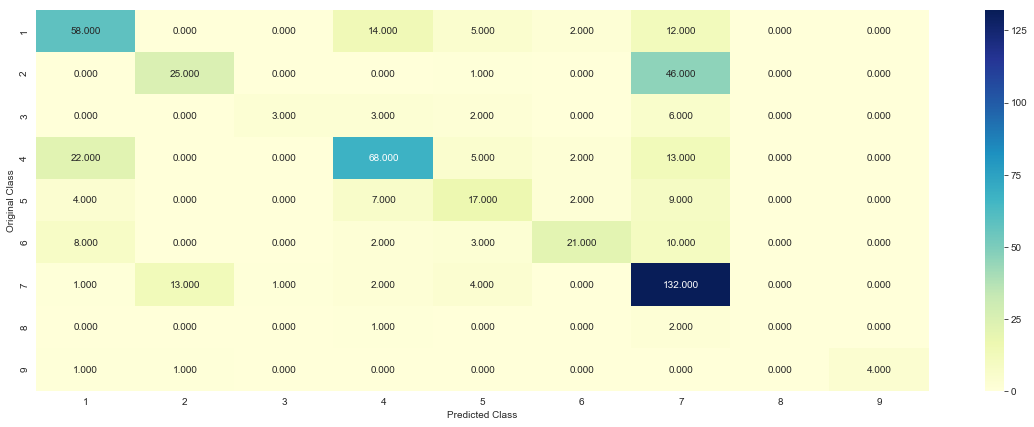

-------------------- Precision matrix (Columm Sum=1) --------------------


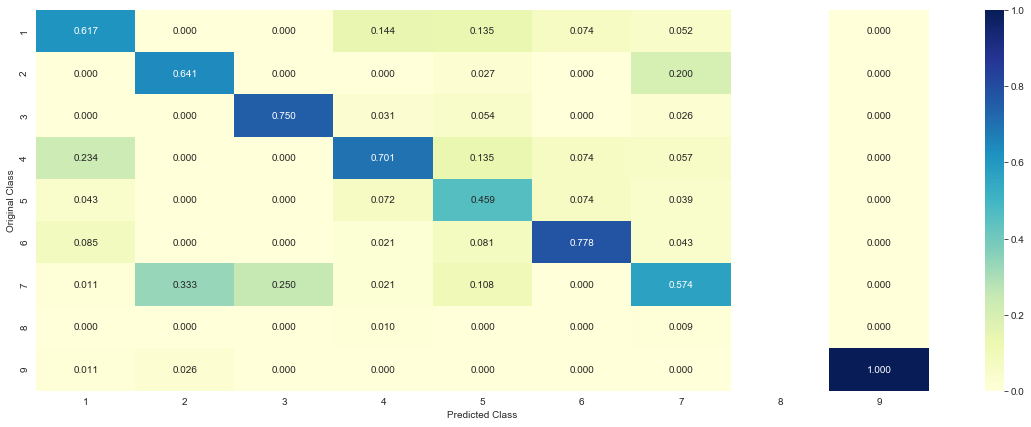

-------------------- Recall matrix (Row sum=1) --------------------


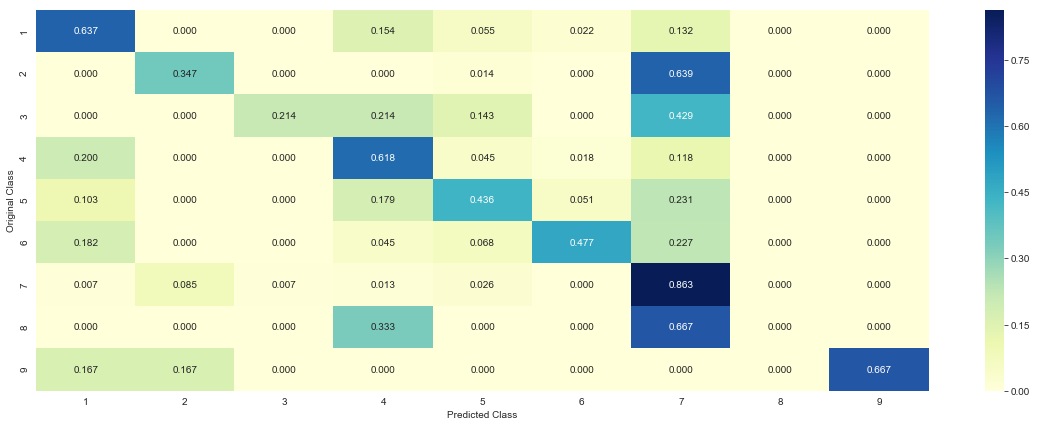

In [90]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of Misclassified points :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### Interpretability of the model

In [91]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0619 0.0867 0.0222 0.0903 0.0482 0.0341 0.6477 0.0054 0.0033]]
Actual Class : 7
--------------------------------------------------
16 Text feature [presence] present in test data point [True]
17 Text feature [downstream] present in test data point [True]
18 Text feature [activating] present in test data point [True]
19 Text feature [kinase] present in test data point [True]
20 Text feature [inhibitor] present in test data point [True]
23 Text feature [recently] present in test data point [True]
24 Text feature [contrast] present in test data point [True]
25 Text feature [cell] present in test data point [True]
26 Text feature [expressing] present in test data point [True]
27 Text feature [cells] present in test data point [True]
29 Text feature [shown] present in test data point [True]
30 Text feature [also] present in test data point [True]
31 Text feature [independent] present in test data point [True]
32 Text feature [previously

In [92]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0583 0.0817 0.021  0.6941 0.0458 0.032  0.0587 0.0052 0.0031]]
Actual Class : 4
--------------------------------------------------
10 Text feature [function] present in test data point [True]
13 Text feature [protein] present in test data point [True]
14 Text feature [experiments] present in test data point [True]
15 Text feature [proteins] present in test data point [True]
16 Text feature [acid] present in test data point [True]
17 Text feature [retained] present in test data point [True]
18 Text feature [mammalian] present in test data point [True]
19 Text feature [activity] present in test data point [True]
20 Text feature [partially] present in test data point [True]
21 Text feature [missense] present in test data point [True]
22 Text feature [functional] present in test data point [True]
26 Text feature [results] present in test data point [True]
27 Text feature [amino] present in test data point [True]
28 Text feature [determ

## K Nearest Neighbour Classification

In [93]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("For alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites log-probability estimates are being used
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.0087496747195508
for alpha = 11
Log Loss : 1.018128346063222
for alpha = 15
Log Loss : 1.0425959349247556
for alpha = 21
Log Loss : 1.0632741013215745
for alpha = 31
Log Loss : 1.0643087644582485
for alpha = 41
Log Loss : 1.063525890860366
for alpha = 51
Log Loss : 1.0642303977725276
for alpha = 99
Log Loss : 1.075410456671865


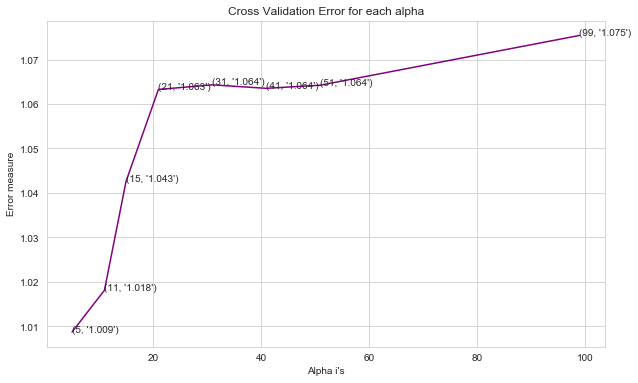

In [94]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='purple')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [95]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  5 The train log loss is: 0.48610147175002416
For values of best alpha =  5 The cross validation log loss is: 1.0087496747195508
For values of best alpha =  5 The test log loss is: 1.0705094181266628


#### Testing the model on test dataset with our best alpha value

Log loss : 1.0087496747195508
Number of mis-classified points : 0.31954887218045114
-------------------- Confusion matrix --------------------


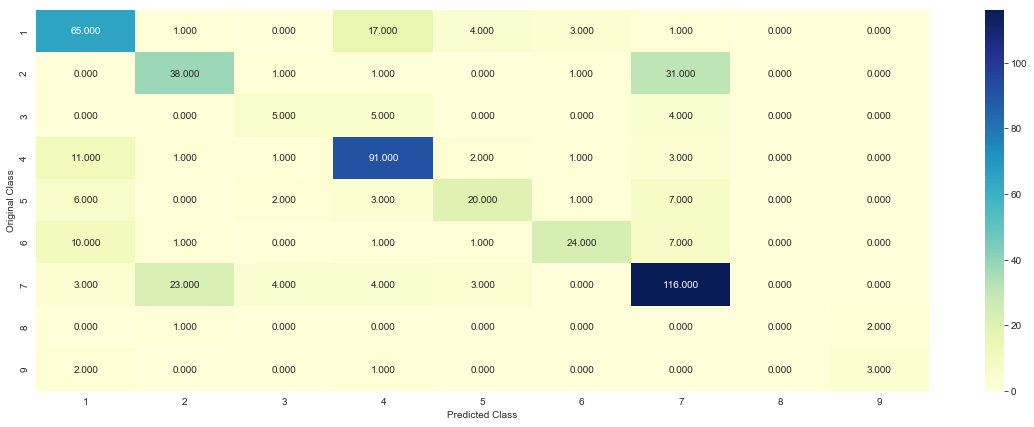

-------------------- Precision matrix (Columm Sum=1) --------------------


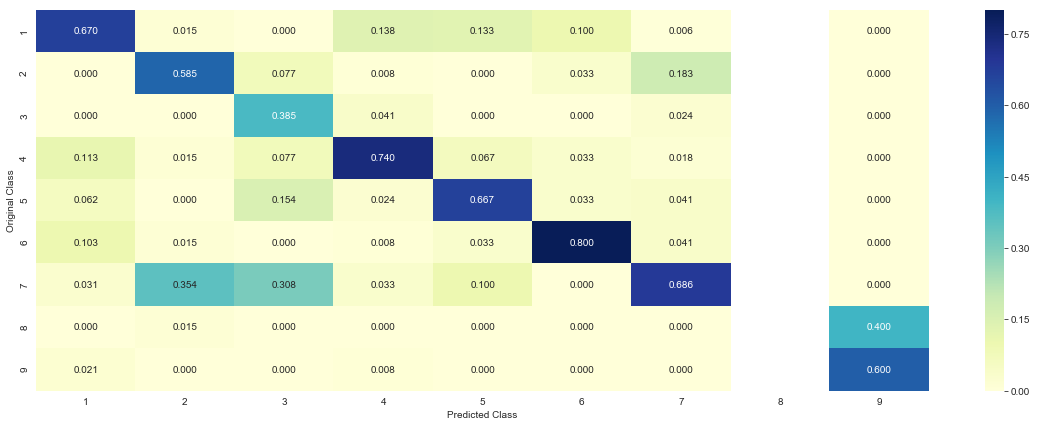

-------------------- Recall matrix (Row sum=1) --------------------


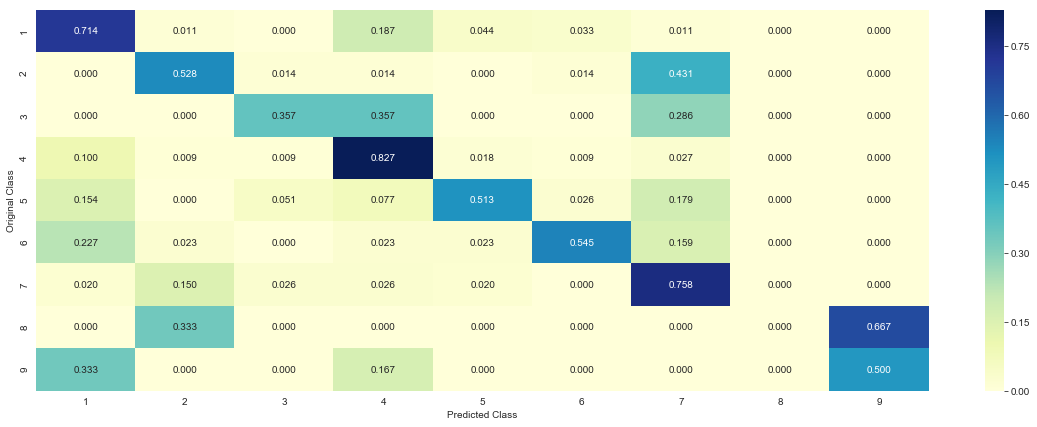

In [96]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

#### Testing some data points

In [97]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 6
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  5  nearest neighbours of the test points belongs to classes [7 7 7 7 3]
Fequency of nearest points : Counter({7: 4, 3: 1})


In [99]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 102

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 3
Actual Class : 3
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [3 3 3 4 5]
Fequency of nearest points : Counter({3: 3, 4: 1, 5: 1})


## Logistic Regression

### Balancing all classes

In [100]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


For alpha = 1e-06
Log Loss : 1.3806632443997995
For alpha = 1e-05
Log Loss : 1.3990874050201008
For alpha = 0.0001
Log Loss : 1.3425792310161995
For alpha = 0.001
Log Loss : 1.130387845492877
For alpha = 0.01
Log Loss : 1.1544287556241983
For alpha = 0.1
Log Loss : 1.470456825594472
For alpha = 1
Log Loss : 1.6816175337503951
For alpha = 10
Log Loss : 1.7065512426480673
For alpha = 100
Log Loss : 1.7093937789581881


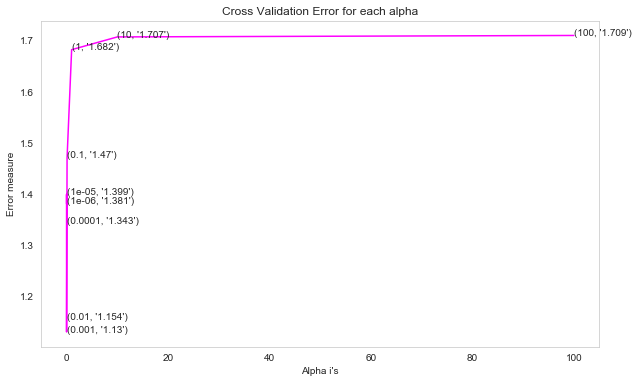

In [101]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='magenta')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [102]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.6315575669292076
For values of best alpha =  0.001 The cross validation log loss is: 1.130387845492877
For values of best alpha =  0.001 The test log loss is: 1.1185869992539221


### Testing on test data using best alpha value

Log loss : 1.130387845492877
Number of mis-classified points : 0.34210526315789475
-------------------- Confusion matrix --------------------


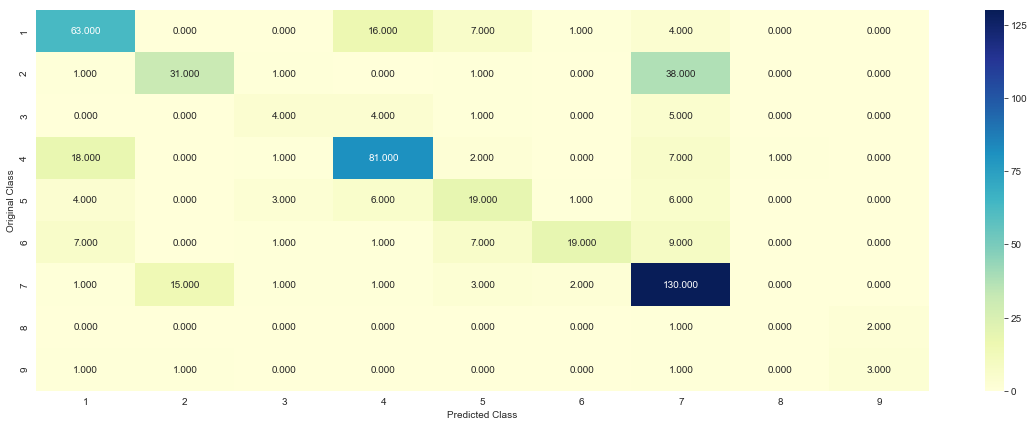

-------------------- Precision matrix (Columm Sum=1) --------------------


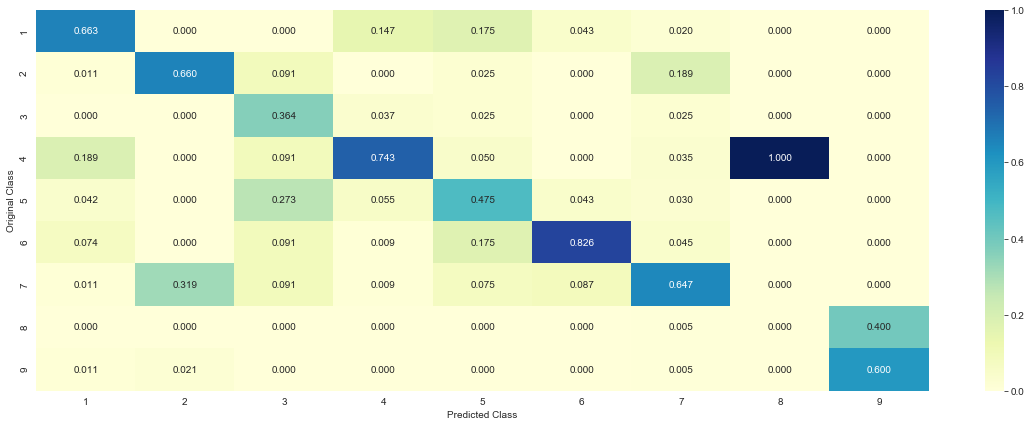

-------------------- Recall matrix (Row sum=1) --------------------


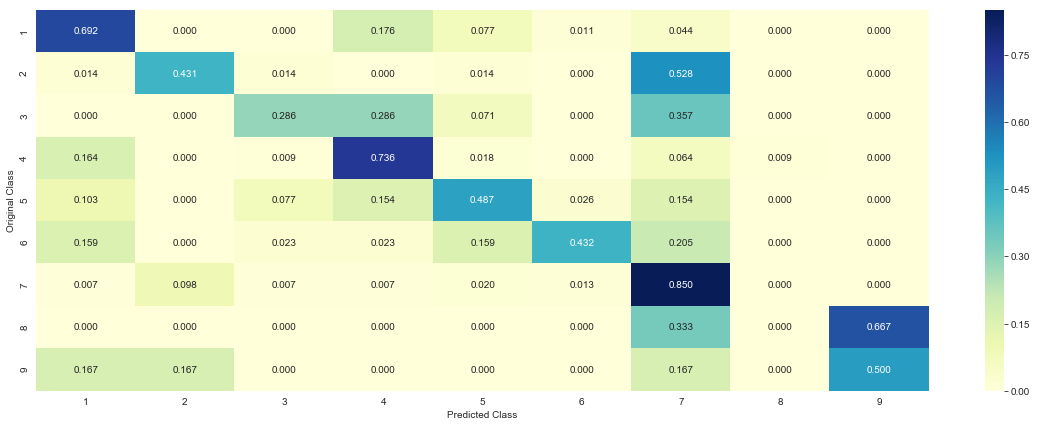

In [103]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Feature importance

In [107]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    increasingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([increasingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([increasingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([increasingorder_ind,train_text_features[i], yes_no])
        increasingorder_ind += 1
    print(word_present, "most important features are present in our query point")
    print("-"*50)
    print("The features that are most important of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

#### Testing query point and doing interpretability

In [108]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0718 0.1327 0.0173 0.0894 0.0615 0.0289 0.5867 0.0051 0.0067]]
Actual Class : 7
--------------------------------------------------
23 Text feature [3t3] present in test data point [True]
31 Text feature [transforming] present in test data point [True]
46 Text feature [constitutive] present in test data point [True]
81 Text feature [activated] present in test data point [True]
119 Text feature [t1n0m0] present in test data point [True]
150 Text feature [transformation] present in test data point [True]
155 Text feature [t1799a] present in test data point [True]
182 Text feature [transducers] present in test data point [True]
199 Text feature [p90rsk] present in test data point [True]
335 Text feature [downstream] present in test data point [True]
499 Text feature [mitogen] present in test data point [True]
Out of the top  500  features  11 are present in query point


In [109]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0066 0.0169 0.026  0.9214 0.0109 0.0029 0.0081 0.0046 0.0026]]
Actual Class : 4
--------------------------------------------------
131 Text feature [suppressor] present in test data point [True]
Out of the top  500  features  1 are present in query point


### Without class balancing

In [110]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.361150211786158
for alpha = 1e-05
Log Loss : 1.3467139143176896
for alpha = 0.0001
Log Loss : 1.3174370749025404
for alpha = 0.001
Log Loss : 1.1443531516338006
for alpha = 0.01
Log Loss : 1.1741272874399789
for alpha = 0.1
Log Loss : 1.3282815105470989
for alpha = 1
Log Loss : 1.5696950783917296


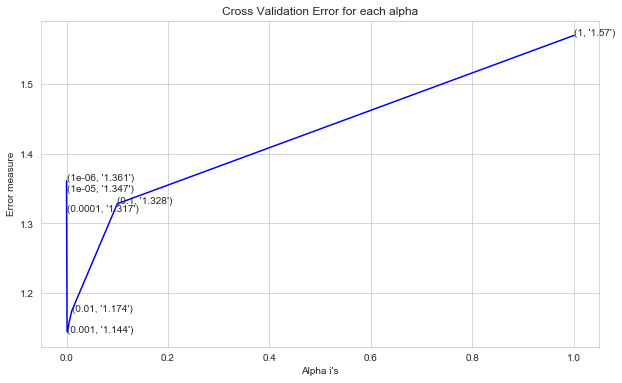

In [111]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='blue')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [112]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.6289688837031985
For values of best alpha =  0.001 The cross validation log loss is: 1.1443531516338006
For values of best alpha =  0.001 The test log loss is: 1.1513767914720372


#### Testing the model with best hyperparameter

Log loss : 1.1443531516338006
Number of mis-classified points : 0.3308270676691729
-------------------- Confusion matrix --------------------


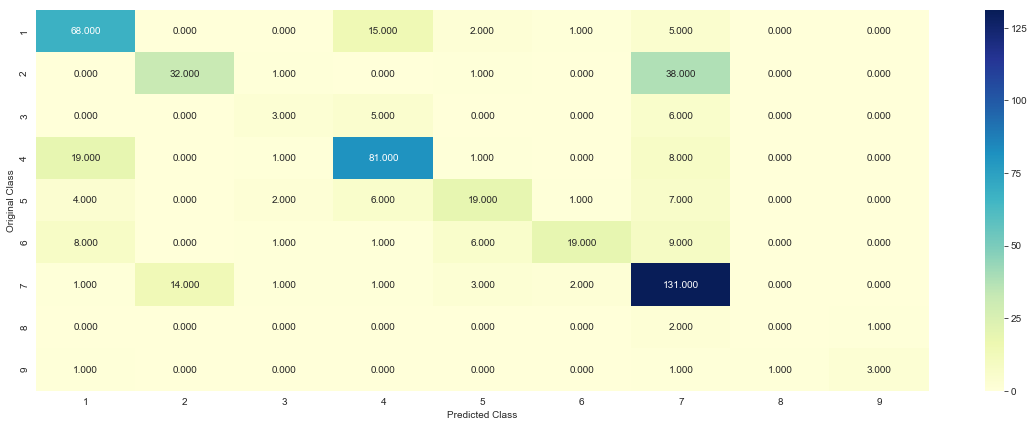

-------------------- Precision matrix (Columm Sum=1) --------------------


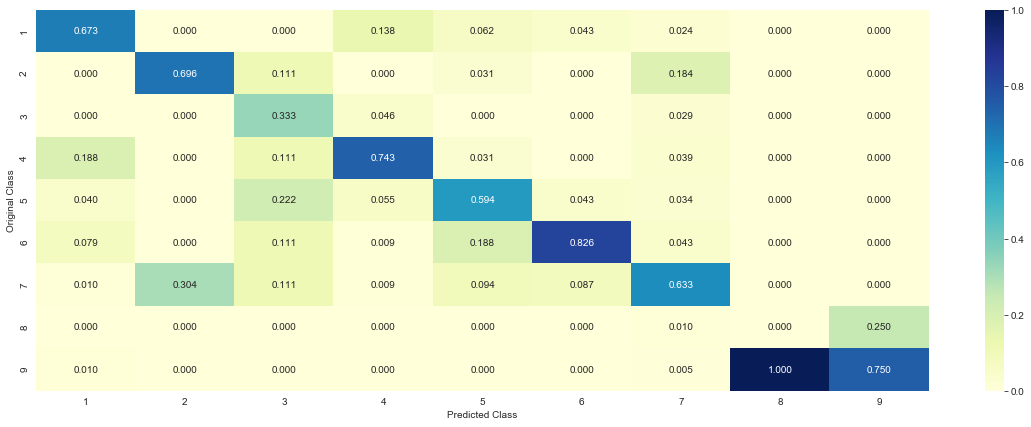

-------------------- Recall matrix (Row sum=1) --------------------


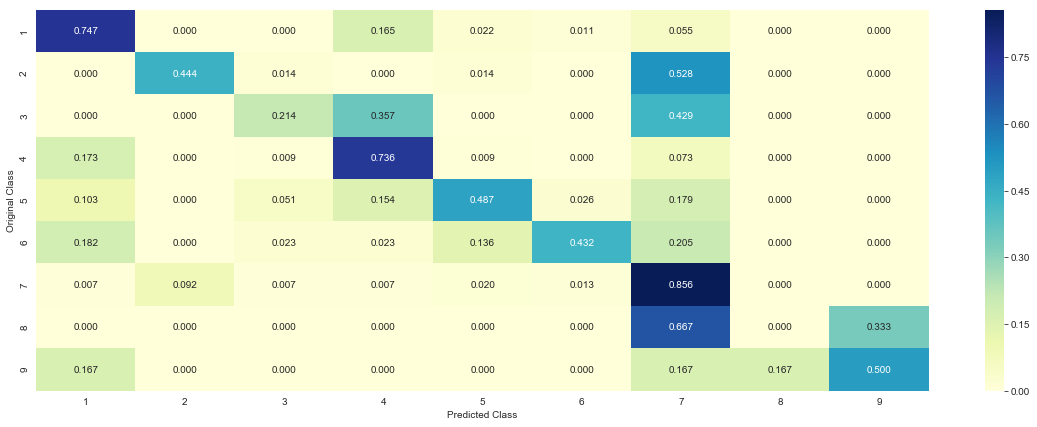

In [113]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### Testing query point and interpretability

In [114]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.074  0.1312 0.015  0.0946 0.0597 0.0295 0.5871 0.0052 0.0037]]
Actual Class : 7
--------------------------------------------------
64 Text feature [3t3] present in test data point [True]
85 Text feature [transforming] present in test data point [True]
133 Text feature [t1799a] present in test data point [True]
151 Text feature [constitutive] present in test data point [True]
200 Text feature [activated] present in test data point [True]
202 Text feature [transformation] present in test data point [True]
334 Text feature [t1n0m0] present in test data point [True]
386 Text feature [mitogen] present in test data point [True]
404 Text feature [p90rsk] present in test data point [True]
460 Text feature [transducers] present in test data point [True]
488 Text feature [ptcs] present in test data point [True]
Out of the top  500  features  11 are present in query point


## Linear Support Vector Machines

In [120]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("For C =", i)
    clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

For C = 1e-05
Log Loss : 1.3796921904233195
For C = 0.0001
Log Loss : 1.3554285059584885
For C = 0.001
Log Loss : 1.2563996333946472
For C = 0.01
Log Loss : 1.1366637814184024
For C = 0.1
Log Loss : 1.3900212159541254
For C = 1
Log Loss : 1.6992810681770476
For C = 10
Log Loss : 1.7098783914502562
For C = 100
Log Loss : 1.7098784214891487


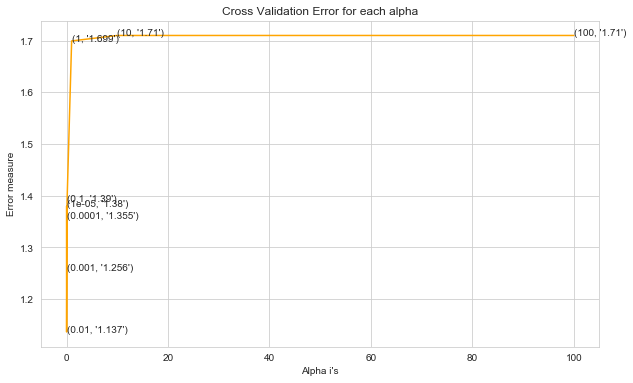

In [119]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='orange')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [121]:
best_alpha = np.argmin(cv_log_error_array)
clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.01 The train log loss is: 0.7582498645388942
For values of best alpha =  0.01 The cross validation log loss is: 1.1366637814184024
For values of best alpha =  0.01 The test log loss is: 1.1572217807789265


### Testing model with best alpha values

Log loss : 1.1366637814184024
Number of mis-classified points : 0.35150375939849626
-------------------- Confusion matrix --------------------


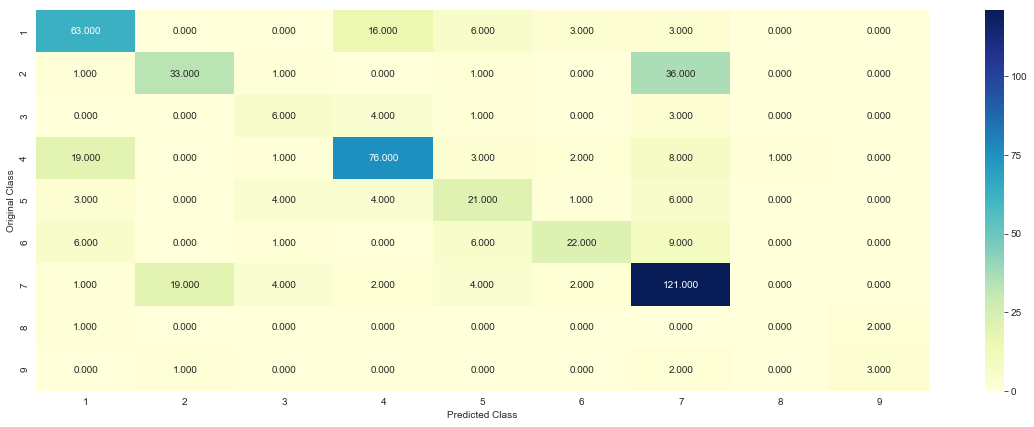

-------------------- Precision matrix (Columm Sum=1) --------------------


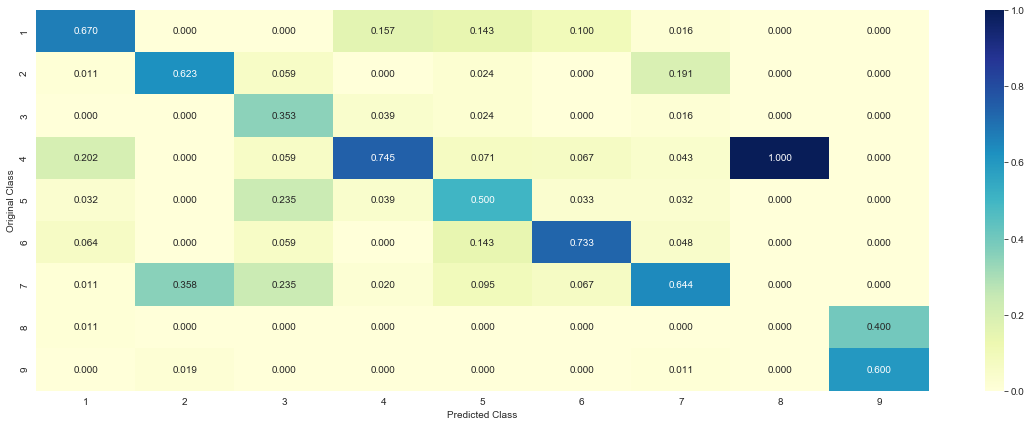

-------------------- Recall matrix (Row sum=1) --------------------


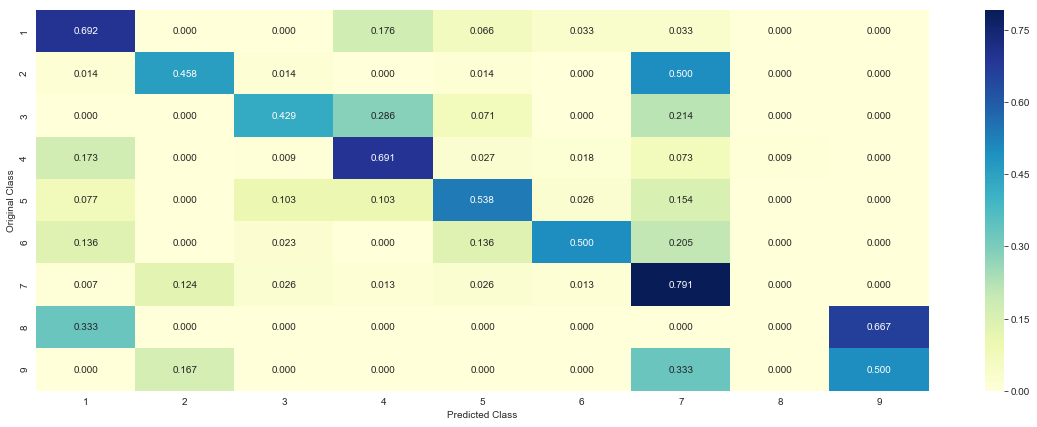

In [122]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### Querying some correctly classified point

In [123]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1102 0.1218 0.0193 0.1261 0.0665 0.0327 0.5117 0.0055 0.0062]]
Actual Class : 7
--------------------------------------------------
26 Text feature [3t3] present in test data point [True]
34 Text feature [transforming] present in test data point [True]
62 Text feature [transducers] present in test data point [True]
75 Text feature [constitutive] present in test data point [True]
96 Text feature [transformation] present in test data point [True]
115 Text feature [activated] present in test data point [True]
151 Text feature [t1n0m0] present in test data point [True]
178 Text feature [thyroid] present in test data point [True]
193 Text feature [ptc] present in test data point [True]
231 Text feature [expressing] present in test data point [True]
232 Text feature [ptcs] present in test data point [True]
285 Text feature [phospho] present in test data point [True]
300 Text feature [mapk] present in test data point [True]
334 Text featur

## Random Forest Classifier

### Model with One hot encoder

In [124]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 1.245054444197193
for n_estimators = 100 and max depth =  10
Log Loss : 1.1926479158581484
for n_estimators = 200 and max depth =  5
Log Loss : 1.2266738149880525
for n_estimators = 200 and max depth =  10
Log Loss : 1.180897021949332
for n_estimators = 500 and max depth =  5
Log Loss : 1.2232724758208318
for n_estimators = 500 and max depth =  10
Log Loss : 1.16812136223963
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2181828068407685
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1593340753776515
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2152780909098424
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1595854806291703


In [125]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  1000 The train log loss is: 0.6881734665951191
For values of best estimator =  1000 The cross validation log loss is: 1.1593340753776515
For values of best estimator =  1000 The test log loss is: 1.1440880221480572


### Testing on test data using best hyperparamater

Log loss : 1.1593340753776515
Number of mis-classified points : 0.4266917293233083
-------------------- Confusion matrix --------------------


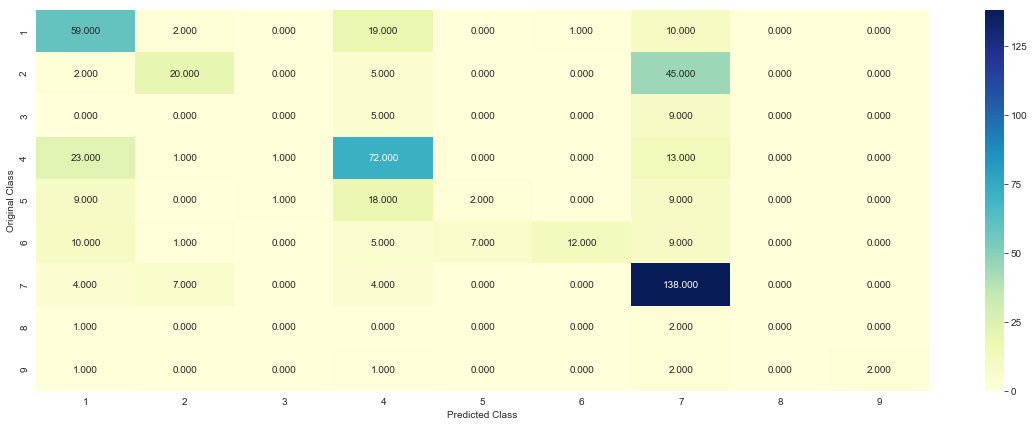

-------------------- Precision matrix (Columm Sum=1) --------------------


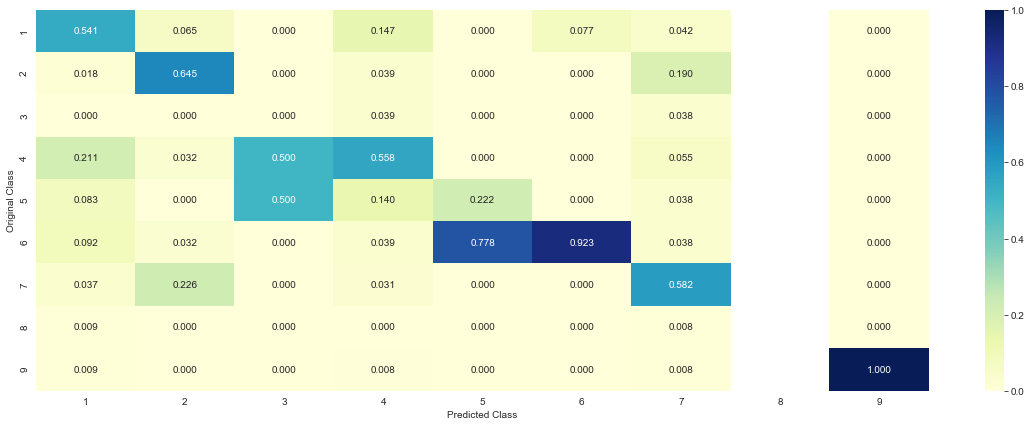

-------------------- Recall matrix (Row sum=1) --------------------


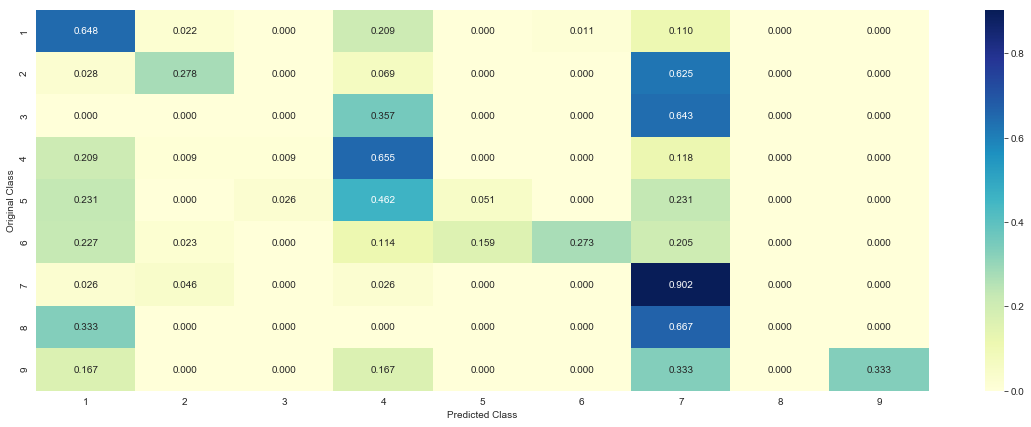

In [126]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [127]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1041 0.1441 0.027  0.1397 0.0614 0.0493 0.4617 0.007  0.0059]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [tyrosine] present in test data point [True]
4 Text feature [activation] present in test data point [True]
6 Text feature [activated] present in test data point [True]
7 Text feature [missense] present in test data point [True]
8 Text feature [signaling] present in test data point [True]
9 Text feature [inhibitor] present in test data point [True]
10 Text feature [function] present in test data point [True]
11 Text feature [treatment] present in test data point [True]
12 Text feature [constitutive] present in test data point [True]
15 Text feature [oncogenic] present in test data point [True]
19 Text feature [phosphorylation] present in test data point [True]
26 Text fea

### Random Forest with Response Coding

In [128]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.094425162537245
for n_estimators = 10 and max depth =  3
Log Loss : 1.6727538228674528
for n_estimators = 10 and max depth =  5
Log Loss : 1.369228893480855
for n_estimators = 10 and max depth =  10
Log Loss : 1.750341099687803
for n_estimators = 50 and max depth =  2
Log Loss : 1.619221145622396
for n_estimators = 50 and max depth =  3
Log Loss : 1.4263850018179824
for n_estimators = 50 and max depth =  5
Log Loss : 1.283365516070406
for n_estimators = 50 and max depth =  10
Log Loss : 1.678304943542966
for n_estimators = 100 and max depth =  2
Log Loss : 1.5022228989260473
for n_estimators = 100 and max depth =  3
Log Loss : 1.4629723694695822
for n_estimators = 100 and max depth =  5
Log Loss : 1.2395470568637181
for n_estimators = 100 and max depth =  10
Log Loss : 1.527203382317063
for n_estimators = 200 and max depth =  2
Log Loss : 1.5711994929253819
for n_estimators = 200 and max depth =  3
Log Loss : 1.4691713507325292
for 

#### Testing model with best hyperparameter

Log loss : 1.2395470568637181
Number of mis-classified points : 0.41729323308270677
-------------------- Confusion matrix --------------------


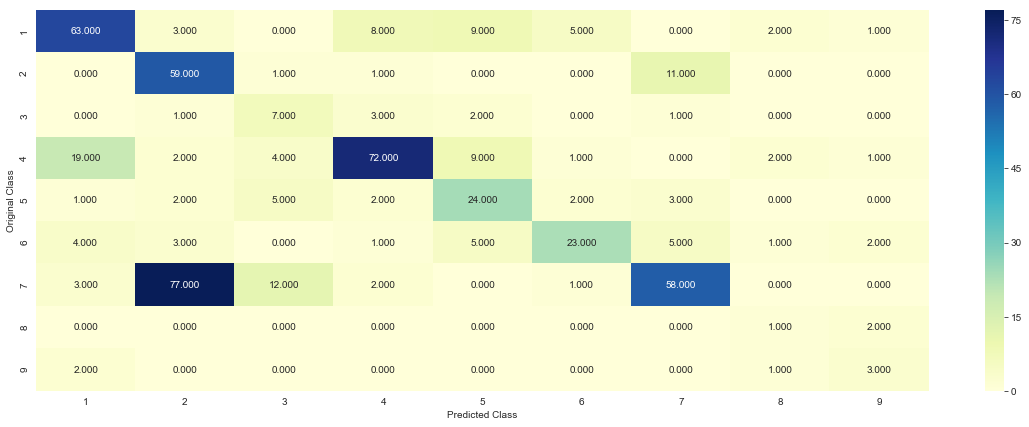

-------------------- Precision matrix (Columm Sum=1) --------------------


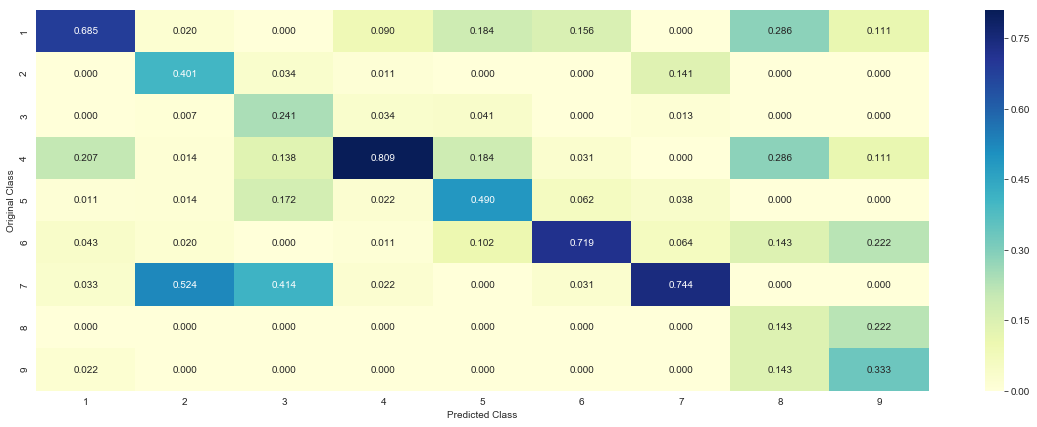

-------------------- Recall matrix (Row sum=1) --------------------


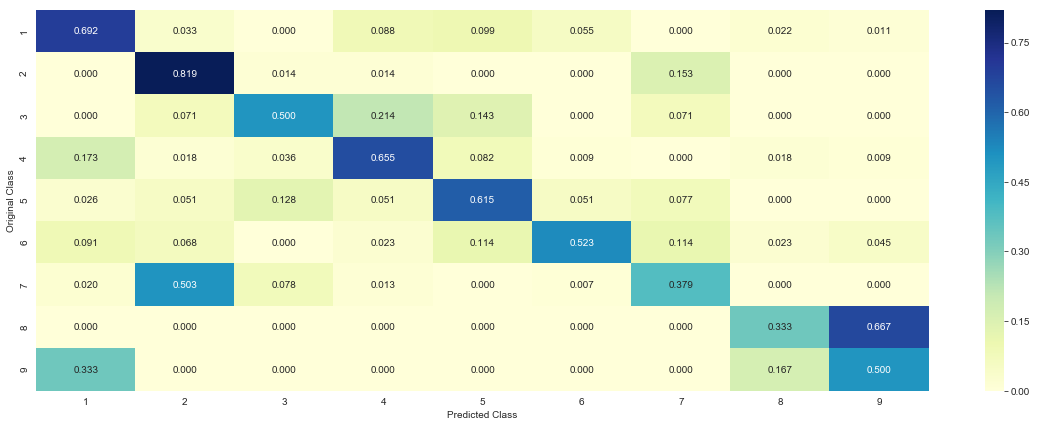

In [129]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

#### Query the classified point

In [130]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.0165 0.3369 0.1477 0.0261 0.0304 0.0384 0.3433 0.0343 0.0264]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


## Stacking model

In [131]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.12
Support vector machines : Log Loss: 1.70
Naive Bayes : Log Loss: 1.30
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.179
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.043
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.535
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.118
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.173
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.416


#### Testing with best hyper param

Log loss (train) on the stacking classifier : 0.6746286094207545
Log loss (CV) on the stacking classifier : 1.1180741048008749
Log loss (test) on the stacking classifier : 1.1625657508122516
Number of misclassified point : 0.38646616541353385
-------------------- Confusion matrix --------------------


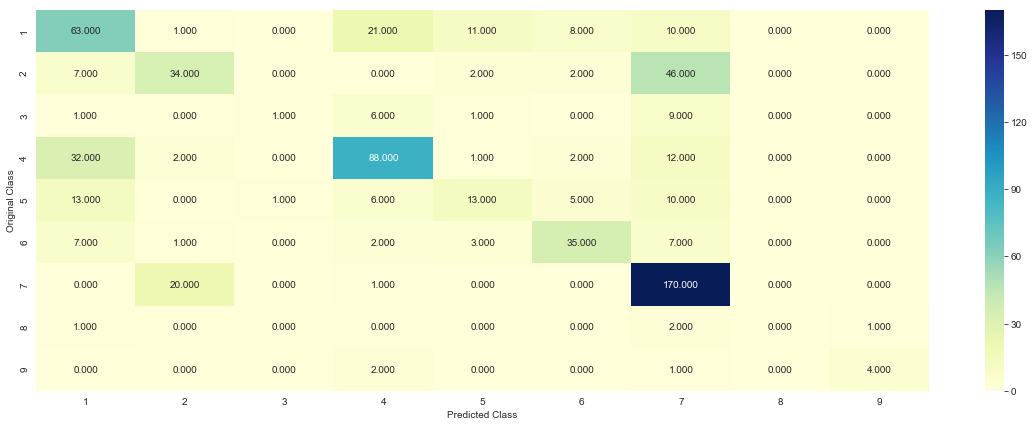

-------------------- Precision matrix (Columm Sum=1) --------------------


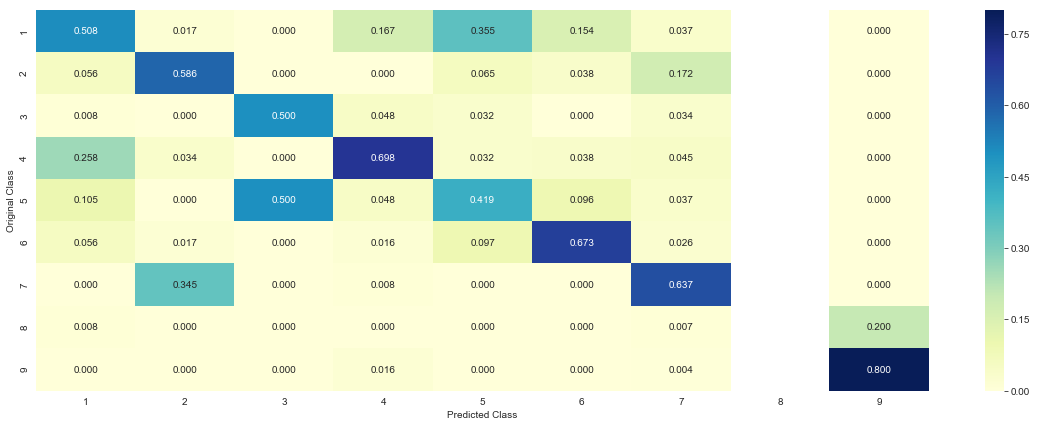

-------------------- Recall matrix (Row sum=1) --------------------


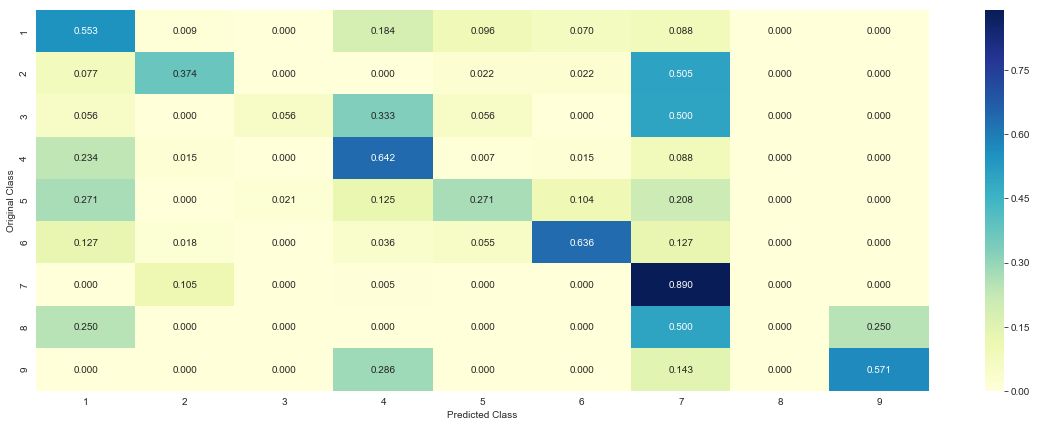

In [133]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of misclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## Maximum voting Classifier

Log loss (train) on the VotingClassifier : 0.9229965201997161
Log loss (CV) on the VotingClassifier : 1.2257630456714663
Log loss (test) on the VotingClassifier : 1.2247555454215866
Number of missclassified point : 0.37293233082706767
-------------------- Confusion matrix --------------------


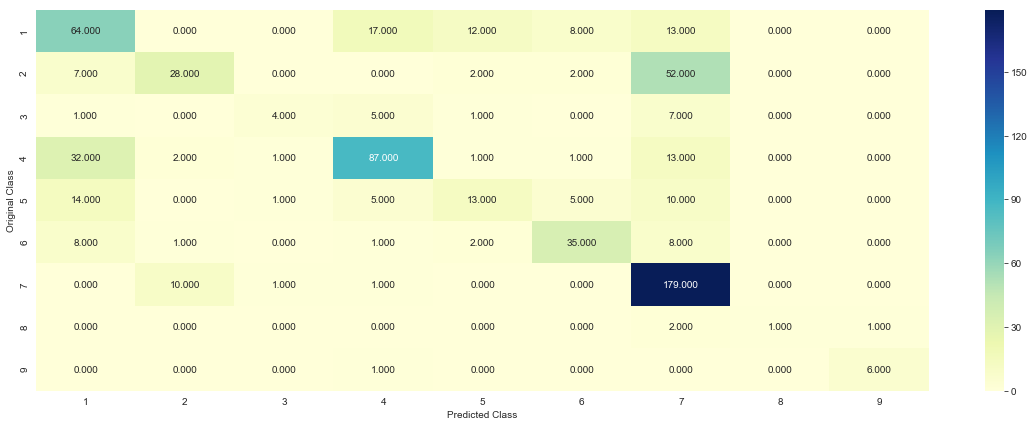

-------------------- Precision matrix (Columm Sum=1) --------------------


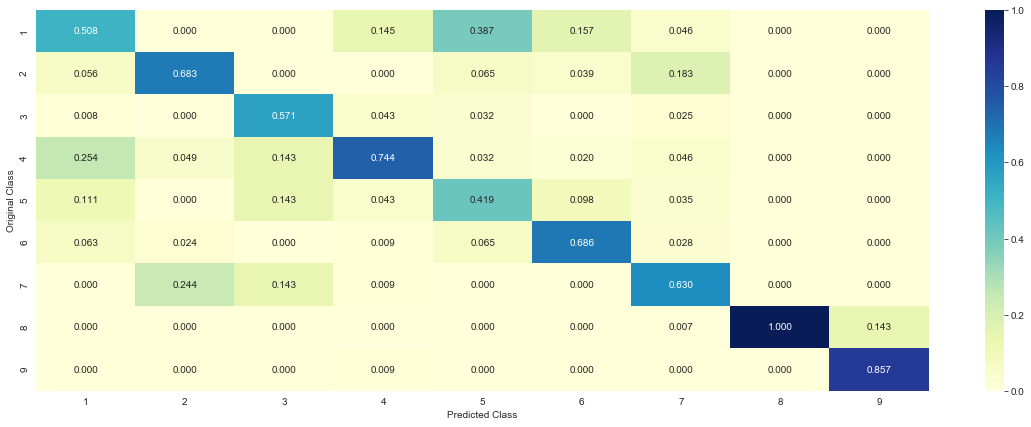

-------------------- Recall matrix (Row sum=1) --------------------


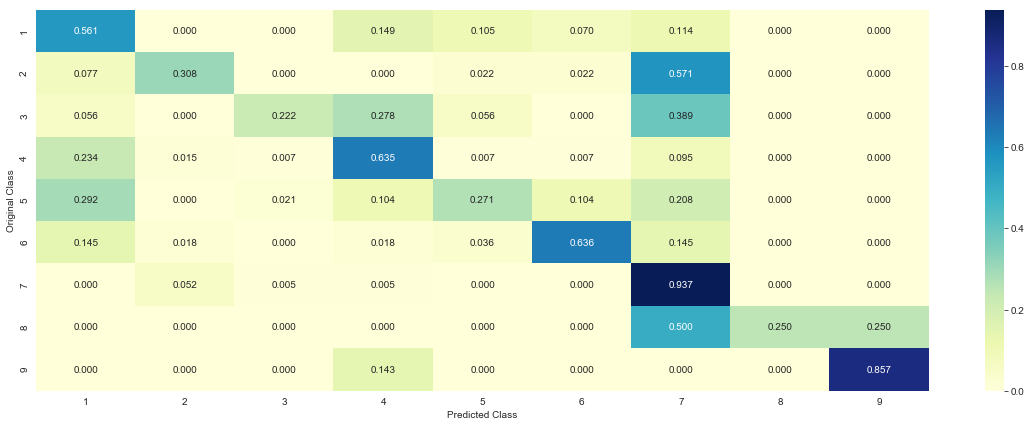

In [134]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))